In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test =pd.read_csv('/kaggle/input/titanic/test.csv')

In [7]:
print(train.head())
print(test.head())
print(train.info())
print(train.isna().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

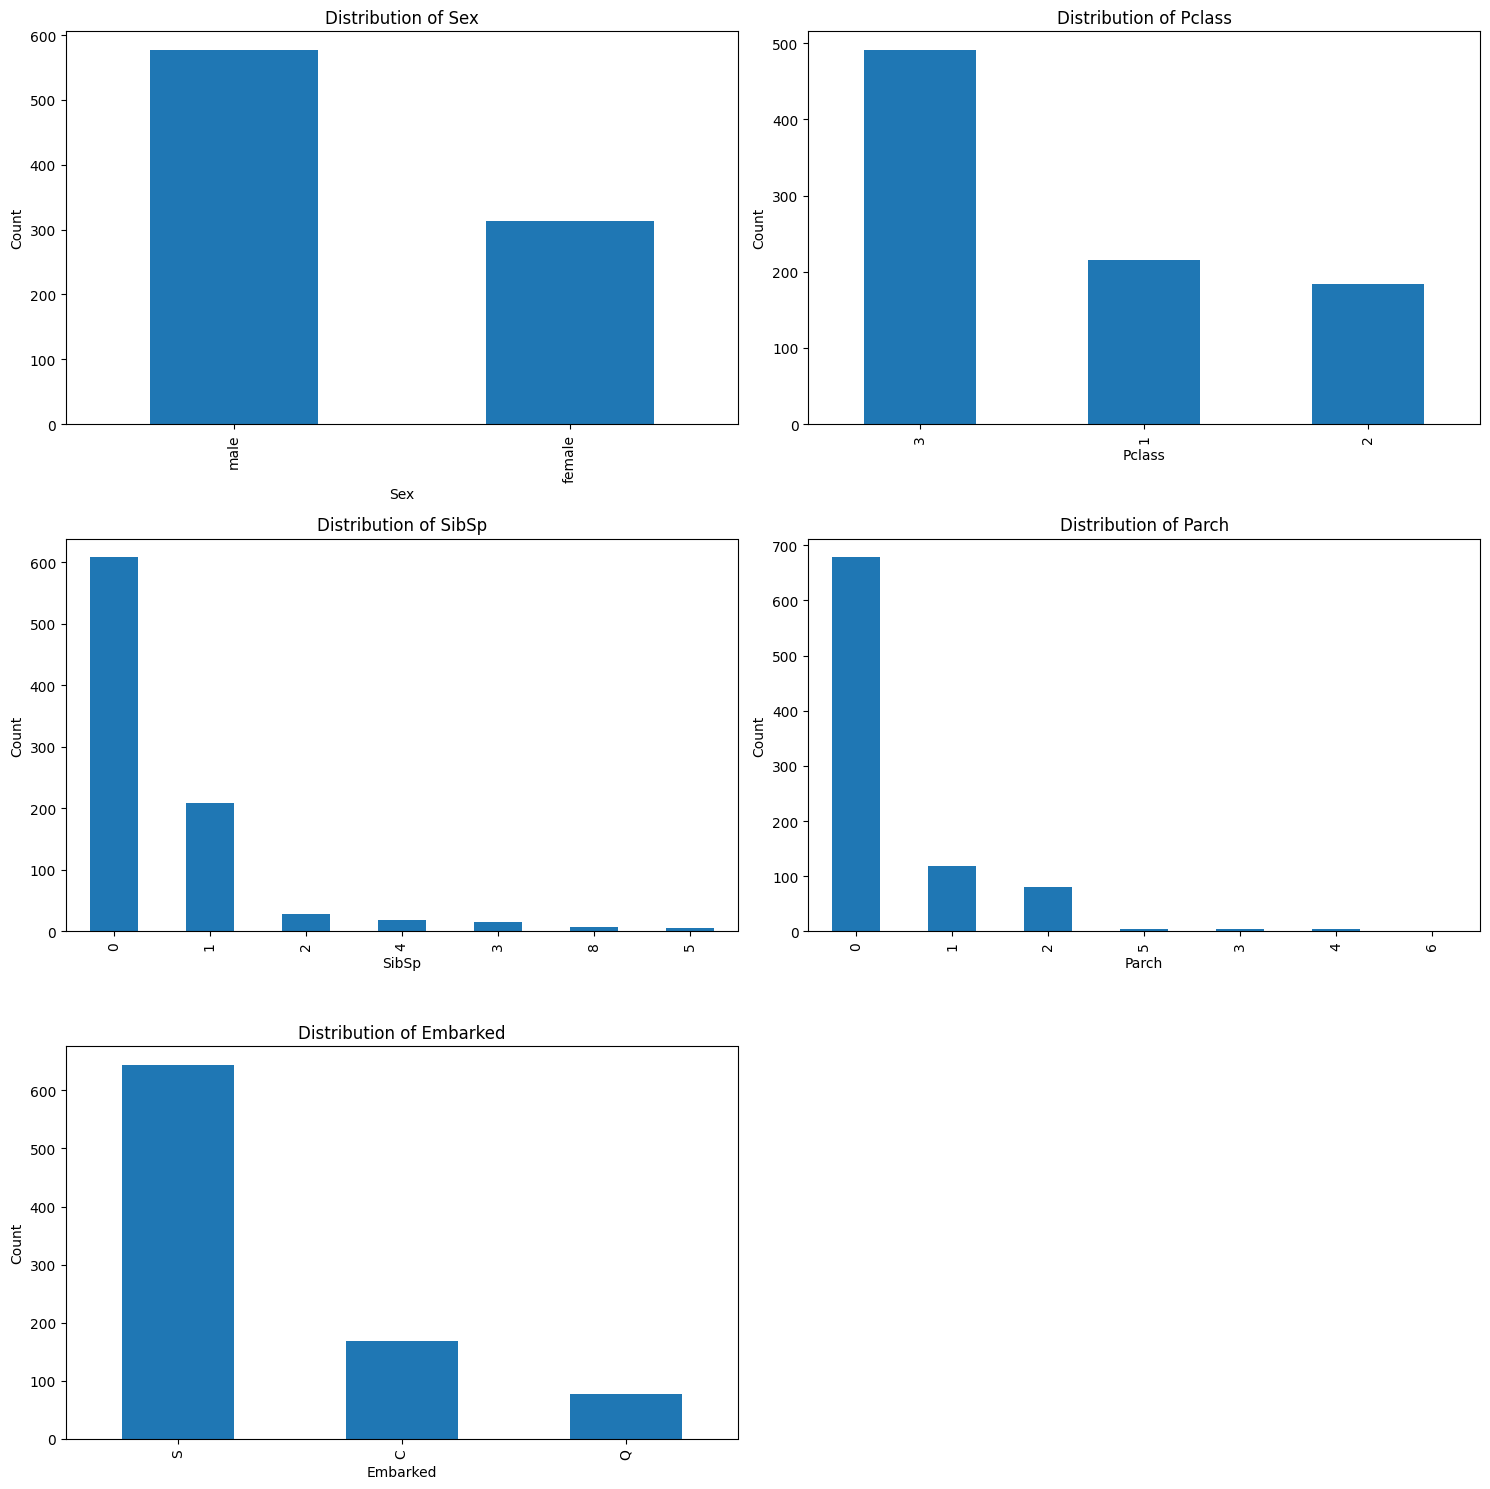

In [8]:
cat_columns =['Sex','Pclass','SibSp','Parch','Embarked']

n_cols=2
n_rows=(len(cat_columns)+ n_cols -1)//n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*5))
axs =axs.flatten()


for i, col in enumerate(cat_columns):
    train[col].value_counts().plot(kind='bar', ax=axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'Distribution of {col}')

for j in range(len(cat_columns), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

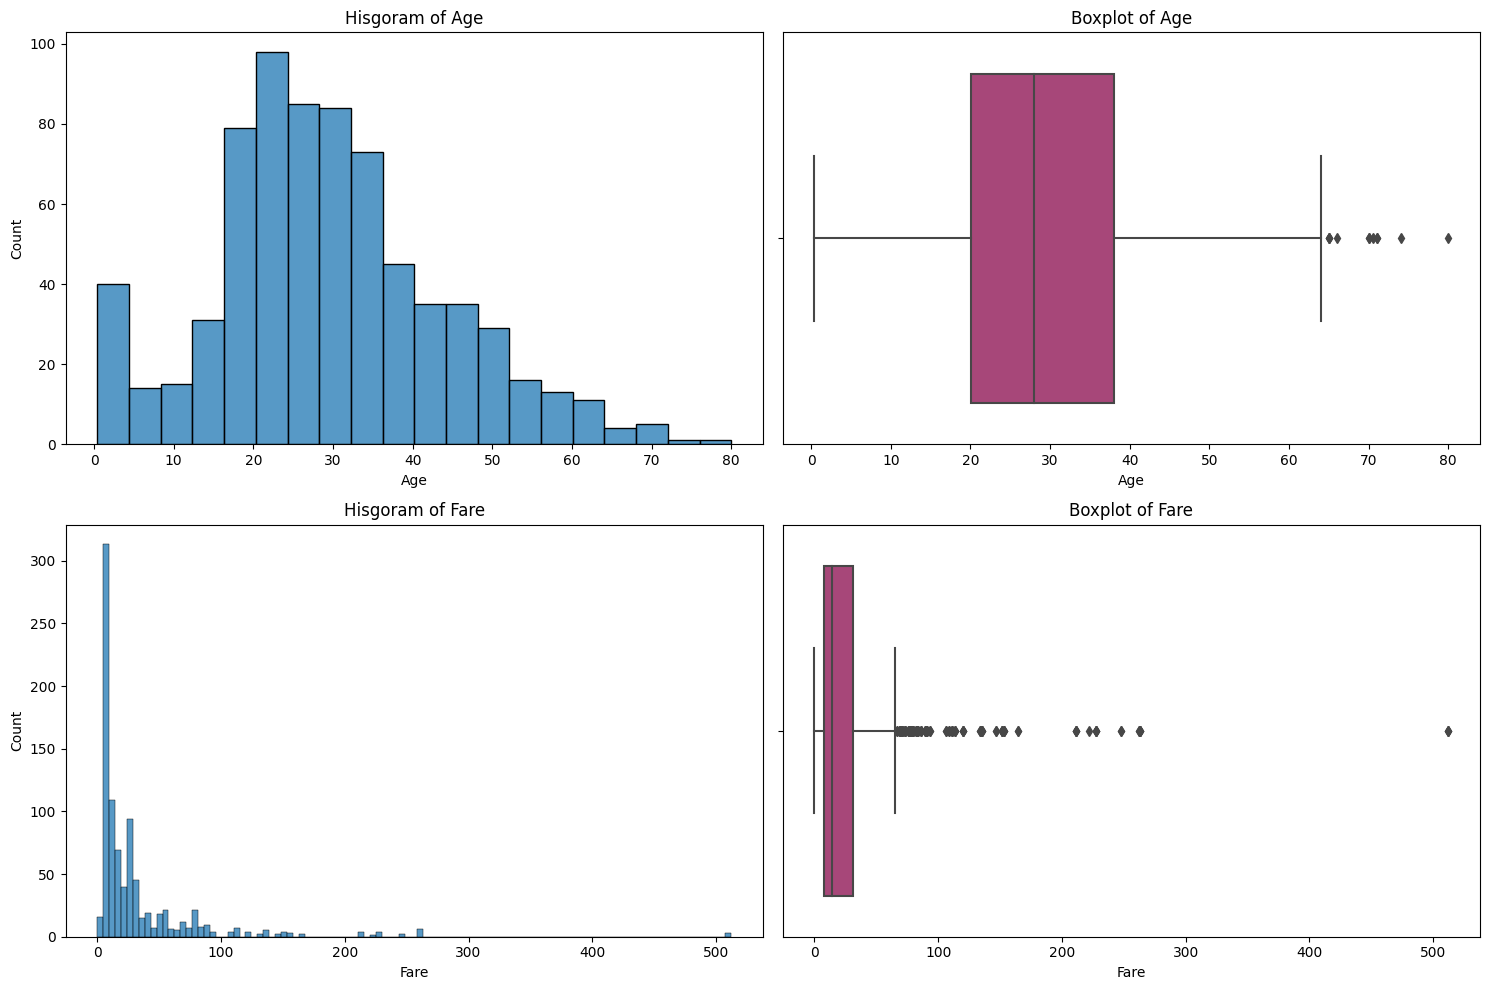

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

con_columns=['Age', 'Fare']

n_rows=len(con_columns)
n_columns=2

fig, axs = plt.subplots(len(con_columns), n_columns, figsize=(15, n_rows*5))

for i, col in enumerate(con_columns):
    sns.histplot(data=train, x=col, ax=axs[i,0])
    axs[i,0].set_title(f'Hisgoram of {col}')

    sns.boxplot(data=train, x=col, palette='magma', ax=axs[i,1])
    axs[i,1].set_title(f'Boxplot of {col}')
 
plt.tight_layout()
plt.show()

warnings.simplefilter(action='default', category=FutureWarning)

In [10]:
#impute 177 missing data in 'Age' with the median (as it is slightly skewed)
train['Age']=train['Age'].fillna(train['Age'].median())

#impute 2 missing data in 'Embarked with a mode'
train['Embarked']=train['Embarked'].fillna(train['Embarked'].mode()[0])

#drop 'Cabin' column with too many missing values(687) with little relevant information
train.drop('Cabin', axis=1, inplace=True)

#drop the outliers in 'Fare'
train=train[train['Fare']<=300]

#check for missing data
print(train.isna().sum())

#check for outlier drop
print(train.shape)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
(888, 11)


In [11]:
print(test.info())
print(test.isna().sum())
test['Age']=test['Age'].fillna(test['Age'].median())
test['Fare']=test['Fare'].fillna(test['Fare'].mode()[0])
test.drop('Cabin', axis=1, inplace=True)
print(test.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex     

In [13]:
train['Family_size']=train['SibSp']+ train['Parch']
bins=[0, 12, 19, 35, 60, 100]

labels = ['1', '2', '3', '4', '5']

train['Age_group']=pd.cut(train['Age'], bins=bins, labels=labels)


In [14]:
test['Family_size']=test['SibSp']+ test['Parch']

bins=[0, 12, 19, 35, 60, 100]
labels = ['1', '2', '3', '4', '5']

test['Age_group']=pd.cut(test['Age'], bins=bins, labels=labels)

In [15]:
feature_columns=['Pclass', 'Sex', 'Age_group', 'Family_size', 'Fare', 'Embarked']

X=train[feature_columns]
X_test=test[feature_columns]

y=train['Survived']

In [16]:
X['Sex']=LabelEncoder().fit_transform(X['Sex'])
X_test['Sex']=LabelEncoder().fit_transform(X_test['Sex'])

In [17]:
X=pd.get_dummies(X, columns=['Embarked'])
X_test=pd.get_dummies(X_test, columns=['Embarked'])
X['Embarked_C']= LabelEncoder().fit_transform(X['Embarked_C'])
X['Embarked_Q']= LabelEncoder().fit_transform(X['Embarked_Q'])
X['Embarked_S']= LabelEncoder().fit_transform(X['Embarked_S'])
X_test['Embarked_C']= LabelEncoder().fit_transform(X_test['Embarked_C'])
X_test['Embarked_Q']= LabelEncoder().fit_transform(X_test['Embarked_Q'])
X_test['Embarked_S']= LabelEncoder().fit_transform(X_test['Embarked_S'])

In [18]:
X['Age_group']=X['Age_group'].astype('int')
X_test['Age_group']=X_test['Age_group'].astype('int')
print(X.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       888 non-null    int64  
 1   Sex          888 non-null    int64  
 2   Age_group    888 non-null    int64  
 3   Family_size  888 non-null    int64  
 4   Fare         888 non-null    float64
 5   Embarked_C   888 non-null    int64  
 6   Embarked_Q   888 non-null    int64  
 7   Embarked_S   888 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 62.4 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    int64  
 2   Age_group    418 non-null    int64  
 3   Family_size  418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Embarked_C   418 non-n

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_val.shape)

(710, 8) (178, 8)


In [20]:
params_rf = {'n_estimators': [50, 100, 200],
             'max_depth': [4, 6],
             'min_samples_leaf': [1, 2], 
             'max_features': ['log2', 'sqrt']}

params_gb = {'n_estimators': [50, 100, 200],
             'learning_rate': [0.01, 0.1],
             'max_depth': [3, 5],
             'subsample': [0.8, 1.0],
             'max_features': ['log2', 'sqrt']}

params_xgb ={'n_estimators': [50, 100, 200],   
         	'learning_rate': [0.01, 0.1],  
         	'max_depth': [3, 5],
         	'min_child_weight': [1, 3],
         	'alpha': [0, 0.1, 0.5]}

models = [("Random Forest", RandomForestClassifier(random_state=1), params_rf),
     	("Gradient Boosting", GradientBoostingClassifier(random_state=1), params_gb),
     	("XGBoost", XGBClassifier(random_state=42, use_label_encoder=False), params_xgb)]

In [21]:
for model_name, model, param_grid in models: 
    grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
    grid_model.fit(X_train, y_train)

    # Get the best model and its accuracy for the train set
    best_model=grid_model.best_estimator_
    best_params = grid_model.best_params_
    accuracy = best_model.score(X_val, y_val)
    print(f'Best parameters for {model_name}:{best_params}')
    print(f'Accuracy for {model_name}: {accuracy}')

    #Get feature importances of the best model
    feature_importances=best_model.feature_importances_

    feature_importances_df=pd.DataFrame({'Feature': X_train.columns, 
                                        'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
    print(f'Feature Importances for {model_name}:')
    print(feature_importances_df)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters for Random Forest:{'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}
Accuracy for Random Forest: 0.8314606741573034
Feature Importances for Random Forest:
       Feature  Importance
1          Sex    0.493264
4         Fare    0.185838
0       Pclass    0.153629
3  Family_size    0.073914
2    Age_group    0.053567
5   Embarked_C    0.019014
7   Embarked_S    0.014780
6   Embarked_Q    0.005993
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for Gradient Boosting:{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 200, 'subsample': 0.8}
Accuracy for Gradient Boosting: 0.8370786516853933
Feature Importances for Gradient Boosting:
       Feature  Importance
1          Sex    0.490714
0       Pclass    0.168483
4         Fare    0.155366
3  Family_size    0.080984
2    Age_group    0.076581
5   Embarked_C    0.013164
7   E

In [22]:
predictions=best_model.predict(X_test)

output=pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
output.to_csv('submission.csv', index=False)
 
print("Your submission was successfully saved!")

Your submission was successfully saved!
